# Bank Marketing Campaign Dataset

## Business Problem Understanding


**Context**

Data yang digunakan adalah data marketing campaign dari sebuah bank. Dimana data ini akan dianalisa dan digunakan untuk memprediksi apakah seorang customer akan melakukan deposit dibank tersebut berdasarkan dari data yang sudah didapatkan.

Deposit:

Yes (1) : melakukan deposit

No (0)  : tidak melakukan deposit

**Problem Statement**

Proses marketing campaign biasanya memakan waktu dan biaya yang tidak sedikit. Perusahaan ingin meningkatkan efisiensi marketing campaign dengan menentukan customer mana yang mempunyai probabilitas tertinggi untuk membuka deposit.

Deposito: Uang yang disimpan dalam rekening yang pada jangka waktu tertentu uang tersebut tidak boleh ditarik nasabah, dan hanya bisa dicairkan pada tanggal jatuh temponya.
https://id.wikipedia.org/wiki/Deposito


**Goals**

Berdasarkan permasalahan tersebut, perusahaan ingin memiliki pemahaman lebih dari data customer mereka untuk bisa memprediksi kemungkinan seorang customer akan membuka deposit atau tidak.

Perusahaan juga ingin mengetahui faktor apa yang membuat seorang customer mau membuka deposit, sehingga perusahaan dapat membuat marketing campaign yang lebih efisien dalam mendekati customer potensial, dan mengurangi biaya berlebih dalam approach ke calon customer yang ternyata tidak berpotensi membuka deposit.

**Analytic Approach**

Pada kasus ini kita akan melakukan analisis data untuk menentukan pola yang membedakan customer yang akan membuka deposit dan yang tidak akan membuka deposit.

Kemudian kita akan membangun model klasifikasi yang akan membantu perusahaan untuk dapat memprediksi probabilitas pembukaan deposit oleh customer.


**Metric Evaluation**

<img src=https://pbs.twimg.com/media/FD2hTDOX0AIdRti.jpg>
<img src=https://miro.medium.com/max/1248/1*vvYZCYycclL6Uozytl9T_A.png>

Type 1 Error : False Positive </br>
Konsekuensi  : Terbuangnya waktu dan biaya campaign tanpa adanya pembukaan deposit

Type 2 Error : False Negative </br>
Konsekuensi  : Kehilangan calon customer yang potensial

Berdasarkan konsekuensinya, maka sebisa mungkin kita membuat model yang mengurangi waktu dan biaya dalam campaign, tanpa membuat kurangnya calon customer potensial. Jadi kita harus antara nilai True Positive dan False Positive. Oleh karena itu kita akan menggunakan **roc_auc** sebagai metric utama. 

## Data Understanding

Dataset source : https://archive.ics.uci.edu/ml/datasets/bank+marketing

Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

Note:

- Data sedikit tidak balance (48:52)
- Kebanyakan datanya berbentuk kategorikal
- Setiap baris menggambarkan data customer yang sudah pernah diapproach dan hasilnya

### Attribute Information

| No. | Attribute | Data Type | About | Description |
| -- | -- | -- | -- | -- |
| 1. | Age | int64 | Client | Client's Age |
| 2. | Job | object | Client | Type of job (admin, blue-collar, entrepreneur, housemaid, management, retired, self-employed, sevices, student, technician, unemployed, unknown) |
| 3. | Balance | int64 | Client | Client's Balance |
| 4. | Housing | object | Client | Has housing loan (Yes, No) |
| 5. | Loan | object | Client | Has personal loan (Yes, No) |
| 6. | Contact | object | Current Campaign | Communication Type (cellular, telephone) |
| 7. | Month | object | Current Campaign | Last contact month of the year |
| 8. | Campaign | int64 | Current Campaign | Number of contacts performed during this campaign and for the client |
| 9. | Pdays | int64 | Previous Campaign | Number of days that passed after the client was last contacted from a previous campaign (999 means client was not previously contacted) |
| 10. | Poutcome | object | Previous Campaign | Outcome of the previous marketing campaign (failure, nonexistent, success) |
| 11. | Deposit | object | Current Campaign | Has the client subscribed a term deposit? (Yes, No) |

### Libraries

In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import category_encoders as ce

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve

## Exploratory Data Analysis (EDA)

### Load Dataset

In [2]:
df = pd.read_csv('data_bank_marketing_campaign.csv')

df.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no


### Dataset Info


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       7813 non-null   int64 
 1   job       7813 non-null   object
 2   balance   7813 non-null   int64 
 3   housing   7813 non-null   object
 4   loan      7813 non-null   object
 5   contact   7813 non-null   object
 6   month     7813 non-null   object
 7   campaign  7813 non-null   int64 
 8   pdays     7813 non-null   int64 
 9   poutcome  7813 non-null   object
 10  deposit   7813 non-null   object
dtypes: int64(4), object(7)
memory usage: 671.6+ KB


Terdapat 7813 baris data pada dataset ini, dimana kebanyakan adalah data kategorikal.

### Missing Values

In [4]:
df.isna().sum()

age         0
job         0
balance     0
housing     0
loan        0
contact     0
month       0
campaign    0
pdays       0
poutcome    0
deposit     0
dtype: int64

Tidak ada missing value didalam dataset ini.

### Features Information

In [5]:
list1 = []
for col in df.columns :
    list1.append([col, df[col].dtype, df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)])

dfInfo = pd.DataFrame(columns=['Features', 'Type', 'Unique', 'Unique Sample'], data=list1)
dfInfo

,Features,Type,Unique,Unique Sample
0,age,int64,75,"[56, 32]"
1,job,object,12,"[blue-collar, housemaid]"
2,balance,int64,3153,"[545, 1730]"
3,housing,object,2,"[no, yes]"
4,loan,object,2,"[no, yes]"
5,contact,object,3,"[unknown, telephone]"
6,month,object,12,"[jan, apr]"
7,campaign,int64,32,"[7, 8]"
8,pdays,int64,422,"[412, 439]"
9,poutcome,object,4,"[success, other]"


#### Categorical Features Subplots

In [6]:
# Buat variabel yang yang berisikan data tipe object
categorical_features =df.select_dtypes(include='object').drop(columns='deposit').columns.tolist()
categorical_features

['job', 'housing', 'loan', 'contact', 'month', 'poutcome']

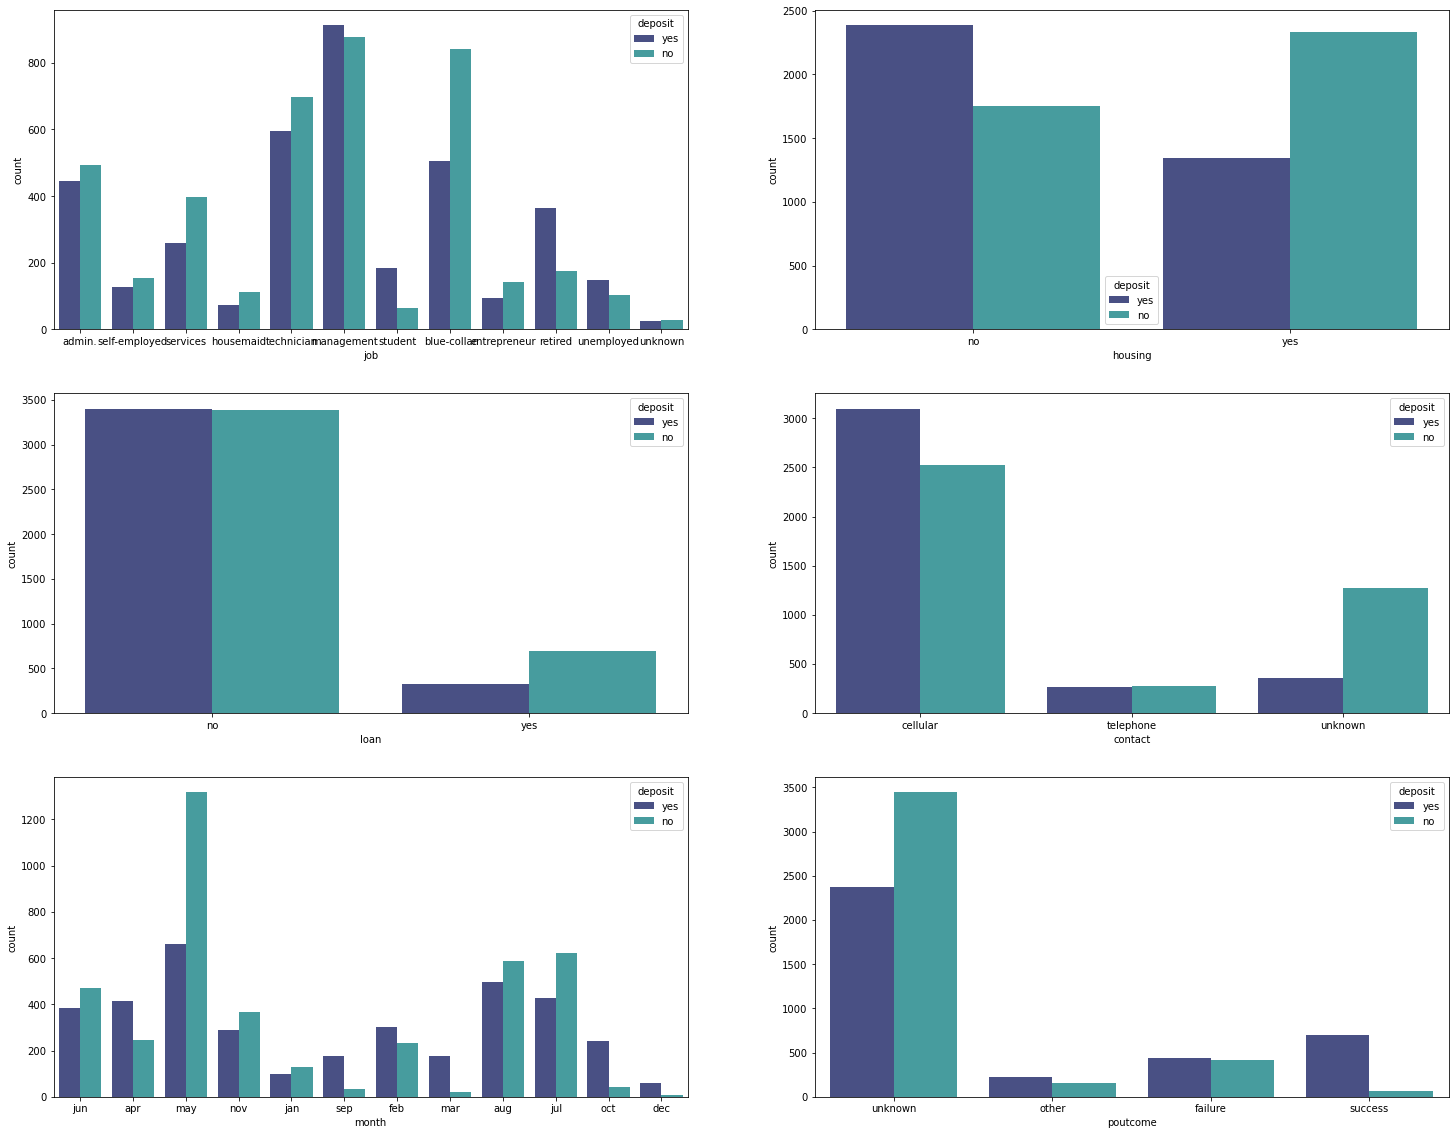

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(25,20))

for i in range(3):
    for j in range(2):
        sns.countplot(x=categorical_features[2*i+j], data=df, palette='mako',hue ='deposit', ax=ax[i,j])




#### Numerical Features Subplots

In [8]:
# Kita buat dulu variabel yang berisikan tipe numerikal
numerical_features = df.select_dtypes(exclude='object').columns.tolist()
numerical_features

['age', 'balance', 'campaign', 'pdays']

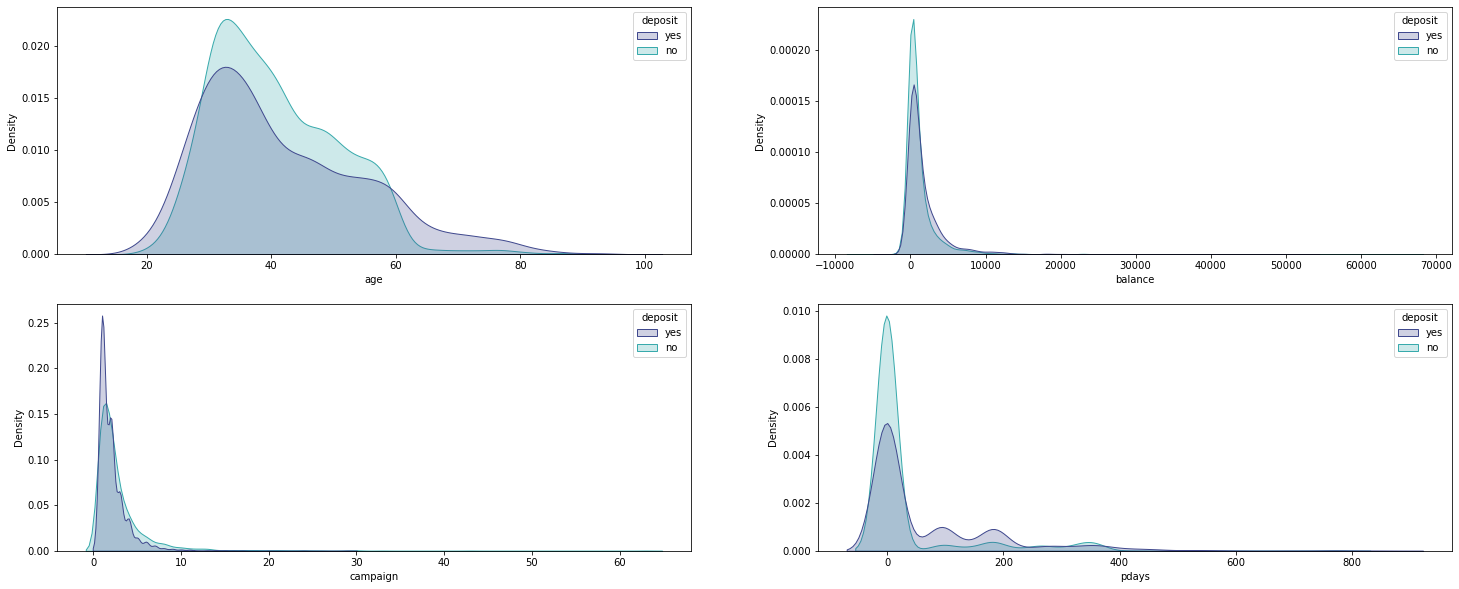

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(25,10))

for i in range(2):
    for j in range(2):
        sns.kdeplot(x=numerical_features[2*i+j], data=df, hue='deposit', palette='mako', fill=True,  ax=ax[i,j])

Dari subplots features diatas terlihat bahwa variabel yang mempunyai persebaran data yang banyak dan berpeluang memberikan insight lebih adalah feature job, month, dan age. Oleh sebab itu kita akan fokus dalam mendalami ketiga feature tersebut.

### Campaign Efficiency Analysis Based on Job, Month, Age, and Balance

Disini kita ingin mengetahui apakah ada pola tertentu antara Job, Month, Age dan Balance dengan Contact sambil melihat pengaruhnya ke Deposit. Features yang dipilih adalah Job, Month, Age dan Balance karena feature tersebut pasti diketahui sebelum kita melakukan campaign kepada calon customer tersebut dan juga memiliki persebaran angka yang luas, sehingga kita ingin mengetahui apakah ada beberapa variabel tertentu yang memiliki pengaruh lebih tinggi dengan metode contact tertentu dan melihat pengaruhnya terhadap target feature (deposit).

Hasil dari analisa ini diharapkan bisa membantu tim marketing untuk bisa lebih efisien dalam melakukan contact ke grup consumer tertentu pada bulan tertentu.

#### Job

Pada analisa feature job, kita tidak akan menganalisa dengan contact tetapi hanya akan melihat menurut deposit rate. Dimana nantinya akan ada jon tertentu yang memiliki peluang lebih tinggi untuk deposit dibandingkan dengan job lain.

In [10]:
# Hitung persentase deposit menurut pekerjaan
deposit_job_pct = pd.crosstab(df['deposit'], df['job']).apply(lambda x:x/x.sum()*100)
# Perhitungan di crosstab dibuat kesamping, agar proporsi perhitungan persentase sesuai dengan deposit (yes/no), bukan menurut pekerjaannya

# Kita akan transpose agar hasilnya berurut kebawah
deposit_job_pct = deposit_job_pct.transpose()

deposit_job_pct


deposit,no,yes
job,,
admin.,52.564103,47.435897
blue-collar,62.555721,37.444279
entrepreneur,60.169492,39.830508
housemaid,60.869565,39.130435
management,48.995536,51.004464
retired,32.407407,67.592593
self-employed,54.642857,45.357143
services,60.486322,39.513678
student,25.506073,74.493927


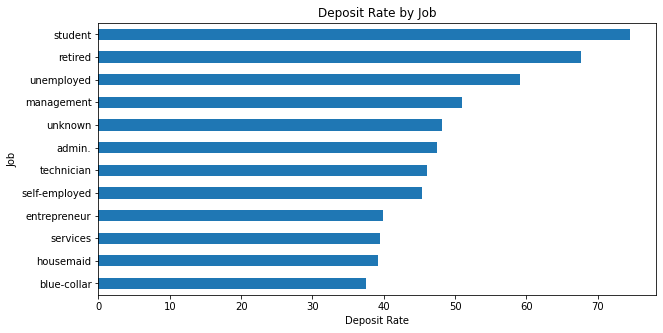

In [11]:
# Kita buat plot hanya yang melakukan deposit saja
deposit_job_yes = deposit_job_pct['yes'].sort_values(ascending=True).plot(kind='barh', figsize=(10,5))

plt.title('Deposit Rate by Job')
plt.xlabel('Deposit Rate')
plt.ylabel('Job')

plt.show()

**Insight**

Terlihat dari horizontal bar chart, bahwa student, retired, unemployed, dan management memiliki peluang deposit rate diatas 50. Berikutnya kita akan analisa berdasarkan month.

#### Month

Disini kita akan menganalisa berdasarkan bulan dilakukannya contact dan dibulan mana yang memiliki deposit rate tertinggi. Analisa ini dilakukan agar kita bisa melihat bulan-bulan mana yang memiliki efisiensi tertinggi untuk menjalankan campaign.

In [12]:
# Buat dataset baru (agar tidak mengubah dataset awal) dimana kita akan buat kolom baru yang diisi dengan bulan dalam bentuk angka
df2 = df.copy()

# Buat kolom baru dimana bulan diubah menjadi integer
list = [df2]
for column in list:
    column.loc[column['month']=='jan', 'month_int'] = 1
    column.loc[column['month']=='feb', 'month_int'] = 2
    column.loc[column['month']=='mar', 'month_int'] = 3
    column.loc[column['month']=='apr', 'month_int'] = 4
    column.loc[column['month']=='may', 'month_int'] = 5
    column.loc[column['month']=='jun', 'month_int'] = 6
    column.loc[column['month']=='jul', 'month_int'] = 7
    column.loc[column['month']=='aug', 'month_int'] = 8
    column.loc[column['month']=='sep', 'month_int'] = 9
    column.loc[column['month']=='oct', 'month_int'] = 10
    column.loc[column['month']=='nov', 'month_int'] = 11
    column.loc[column['month']=='dec', 'month_int'] = 12

df2

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit,month_int
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes,6.0
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes,4.0
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes,5.0
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no,5.0
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7808,62,housemaid,2,no,no,cellular,nov,1,-1,unknown,yes,11.0
7809,48,housemaid,5473,no,no,cellular,feb,2,184,success,yes,2.0
7810,36,unknown,179,no,no,cellular,aug,8,-1,unknown,no,8.0
7811,31,admin.,54,yes,no,cellular,nov,1,-1,unknown,no,11.0


In [13]:
# Buat crosstab menggunakan kolom bulan yang sudah dibuat
month_deposit = pd.crosstab(df2['deposit'], df2['month_int']).apply(lambda x:x/x.sum()*100)

# Transpose 
month_deposit = month_deposit.transpose()

month_deposit

deposit,no,yes
month_int,,
1.0,56.387665,43.612335
2.0,43.632959,56.367041
3.0,11.055276,88.944724
4.0,37.311178,62.688822
5.0,66.649798,33.350202
6.0,55.075846,44.924154
7.0,59.142857,40.857143
8.0,54.285714,45.714286
9.0,16.037736,83.962264


In [14]:
# Kita akan membuat dataframe baru dimana kita akan melihat hubungan antara contact rate dan deposit rate pada bulan tersebut
month = pd.DataFrame(df2['month_int'].value_counts())
month['contact_pct'] = month['month_int']*100/month['month_int'].sum()
month['deposit_pct'] = month_deposit['yes']

month.drop('month_int', axis=1, inplace=True)

month


,contact_pct,deposit_pct
5.0,25.291181,33.350202
8.0,13.887111,45.714286
7.0,13.439140,40.857143
6.0,10.968898,44.924154
4.0,8.473058,62.688822
11.0,8.409062,44.140030
2.0,6.834763,56.367041
10.0,3.660566,84.965035
1.0,2.905414,43.612335
9.0,2.713426,83.962264


In [15]:
# Kita urutkan data diatas agar bisa diplot
month['month'] = [5,8,7,6,4,11,2,10,1,9,3,12]
month = month.sort_values('month', ascending=True)

month

,contact_pct,deposit_pct,month
1.0,2.905414,43.612335,1
2.0,6.834763,56.367041,2
3.0,2.547037,88.944724,3
4.0,8.473058,62.688822,4
5.0,25.291181,33.350202,5
6.0,10.968898,44.924154,6
7.0,13.439140,40.857143,7
8.0,13.887111,45.714286,8
9.0,2.713426,83.962264,9
10.0,3.660566,84.965035,10


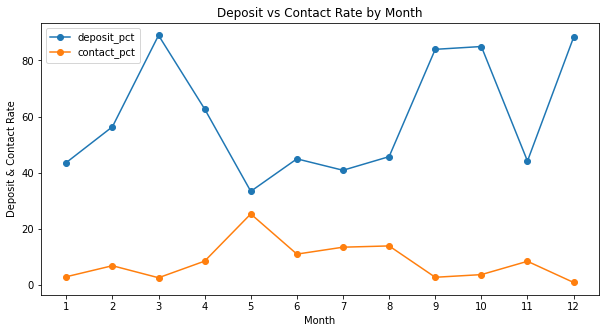

In [16]:
# Gambar line chart dari data diatas
month[['deposit_pct','contact_pct']].plot(kind='line', figsize=(10,5), marker='o')

plt.title('Deposit vs Contact Rate by Month')
plt.xlabel('Month')
plt.ylabel('Deposit & Contact Rate')
plt.xticks(np.arange(1,13,1))

plt.show()

**Insight**

- Rata-rata contact rate tinggi ada diantara bulan mei sampai agustus, dimana paling tinggi ada di bulan Mei. Lalu trendnya cenderung turun diakhir dan awal tahun
- Jika dibandingkan dengan deposit rate, justru pergerakannya adalah kebalikan dari contact rate. Pada bulan Mei dimana contact rate tertinggi, deposit rate justru pada angka terendahnya
- Dari chart ini kita bisa menyimpulkan bahwa bisa dilakukannya perbaikan dalam melakukan contact ke customer

#### Age

Dalam menganalisa usia, kita akan membagi ke beberapa bin (5), untuk mempermudah menganalisa datanya. Kita akan lihat menurut contact ratenya, untuk mengetahui apakah ada kelompok umur tertentu yang bisa dijadikan target utama dalam campaign.

Bin akan dibagi menjadi <30, 30, 40, 50, >60. Dibagi sedemikian karena melihat usia produktifnya.

In [17]:
# Bagi age menjadi beberapa bin
list2 = [df2]
for column in list2:
    column.loc[column['age'] < 30, 'age_group'] = 20  # Usia 0-29 akan masuk ke grup 20
    column.loc[(column['age'] >=30) & (column['age'] <= 39), 'age_group'] = 30  # Usia 30-39 akan masuk grup 30
    column.loc[(column['age'] >=40) & (column['age'] <= 49), 'age_group'] = 40  # Usia 40-49 akan masuk grup 40
    column.loc[(column['age'] >=50) & (column['age'] <= 59), 'age_group'] = 50  # Usia 50-59 akan masuk grup 50
    column.loc[(column['age'] >= 60), 'age_group'] = 60  # Usia >=60 masuk ke grup 60

df2


,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit,month_int,age_group
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes,6.0,50.0
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes,4.0,30.0
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes,5.0,50.0
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no,5.0,30.0
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no,11.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7808,62,housemaid,2,no,no,cellular,nov,1,-1,unknown,yes,11.0,60.0
7809,48,housemaid,5473,no,no,cellular,feb,2,184,success,yes,2.0,40.0
7810,36,unknown,179,no,no,cellular,aug,8,-1,unknown,no,8.0,30.0
7811,31,admin.,54,yes,no,cellular,nov,1,-1,unknown,no,11.0,30.0


In [18]:
# Buat crosstab untuk menghitung persentase deposit rate
age_deposit = pd.crosstab(df2['deposit'], df2['age_group']).apply(lambda x:x/x.sum()*100)

# Transpose
age_deposit = age_deposit.transpose()

age_deposit

deposit,no,yes
age_group,,
20.0,41.148776,58.851224
30.0,55.294118,44.705882
40.0,59.366466,40.633534
50.0,56.475096,43.524904
60.0,23.063063,76.936937


In [19]:
# Buat dataframe baru yang berisikan persentase yang dikontak dan yang melakukan deposit
age = pd.DataFrame(df2['age_group'].value_counts())
age['contact_pct'] = age['age_group']*100/age['age_group'].sum()
age['deposit_pct'] = age_deposit['yes']

age.drop('age_group', axis=1, inplace=True)

age

,contact_pct,deposit_pct
30.0,39.165493,44.705882
40.0,23.435300,40.633534
50.0,16.702931,43.524904
20.0,13.592730,58.851224
60.0,7.103545,76.936937


In [20]:
# Urutkan data diatas sesuai grupnya
age['age'] = [30,40,50,60,20]

age = age.sort_values('age', ascending=True)

age

,contact_pct,deposit_pct,age
60.0,7.103545,76.936937,20
30.0,39.165493,44.705882,30
40.0,23.435300,40.633534,40
50.0,16.702931,43.524904,50
20.0,13.592730,58.851224,60


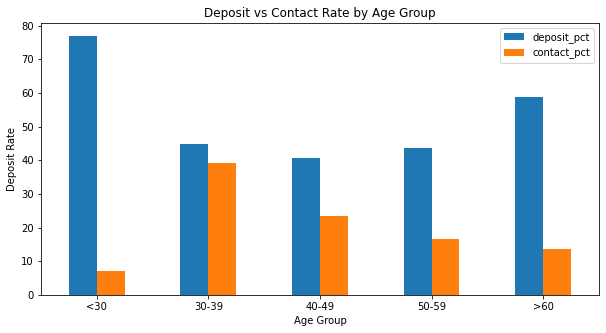

In [21]:
age[['deposit_pct','contact_pct']].plot(kind='bar', figsize=(10,5))

plt.title('Deposit vs Contact Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Deposit Rate')
plt.xticks(np.arange(5),('<30', '30-39','40-49','50-59','>60'), rotation='horizontal')

plt.show()

**Insight**

- Bisa dilihat bahwa jumlah customer yang memiliki peluang deposit yang tinggi ada di grup <30 dan >60
- Sedangkan contact rate di kedua grup tersebut adalah yang terendah
- Jika dilihat dari jenis investasinya (deposit), anak muda dan orang tua memang lebih cenderung memilih deposit dibandingkan pada customer yang di usia kerja. Karena memang lebih rendah resikonya, namun hasilnya juga lebih terjamin returnnya walaupun tidak besar. Sedangkan untuk mereka yang sedang di usia produktif, kemungkinan lebih memilih jenis investasi lain yang lebih beresiko dan lebih tinggi returnnya.
- Chart ini juga menjustifikasi temuan kita pada chart job, dimana student dan retired menempati 2 posisi teratas pada job yang memiliki deposit rate yang tinggi.
- Data ini bisa menjadi masukan kepada tim marketing untuk bisa memfokuskan lebih banyak resource ke kedua grup tersebut

#### Balance


In [22]:
# Sama seperti age, kita akan bagi balance menjadi grup (4)
list3 = [df2]
for column in list3:
    column.loc[column['balance'] <= 0, 'balance_group'] = '0' #Kita akan group yang 0 dan minus 
    column.loc[(column['balance'] > 0) & (column['balance'] <= 1000), 'balance_group'] = '0-1000' #Balance rendah
    column.loc[(column['balance'] > 1000) & (column['balance'] <= 10000), 'balance_group'] = '1000-10000' #Balance standar
    column.loc[(column['balance'] > 10000), 'balance_group'] = '>10000' #Balance tinggi

In [23]:
# Buat crosstabnya
balance_deposit = pd.crosstab(df2['deposit'], df2['balance_group']).apply(lambda x:x/x.sum()*100)

# Transpose
balance_deposit = balance_deposit.transpose()

balance_deposit

deposit,no,yes
balance_group,,
0,66.146341,33.853659
0-1000,54.895545,45.104455
1000-10000,43.825301,56.174699
>10000,36.477987,63.522013


In [24]:
# Gabungkan data yang sudah disiapkan
balance = pd.DataFrame(df2['balance_group'].value_counts())
balance['contact_pct'] = balance['balance_group']*100/balance['balance_group'].sum()
balance['deposit_pct'] = balance_deposit['yes']
balance.drop('balance_group', axis=1, inplace=True)

balance

,contact_pct,deposit_pct
0-1000,50.851146,45.104455
1000-10000,33.994624,56.174699
0,13.119160,33.853659
>10000,2.035070,63.522013


In [25]:
# Urutkan tabel diatas
balance['rank'] = [1,2,0,3]
balance = balance.sort_values('rank', ascending=True)
balance

,contact_pct,deposit_pct,rank
0,13.119160,33.853659,0
0-1000,50.851146,45.104455,1
1000-10000,33.994624,56.174699,2
>10000,2.035070,63.522013,3


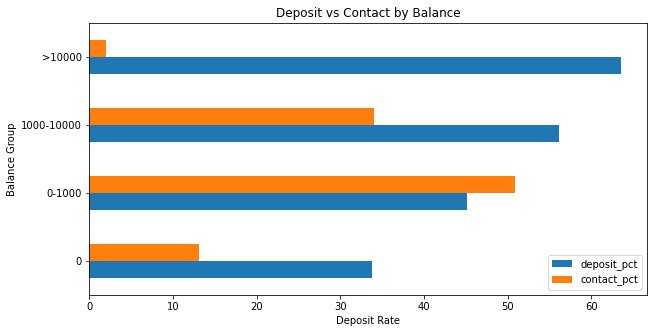

In [26]:
balance[['deposit_pct','contact_pct']].plot(kind='barh', figsize=(10,5))

plt.title('Deposit vs Contact by Balance')
plt.xlabel('Deposit Rate')
plt.ylabel('Balance Group')

plt.show()

**Insight**

- Dari grafik diatas kita bisa lihat bahwa semakin tinggi balancenya semakin tinggi peluang calon customer untuk membuka deposit (terutama diatas 1000, peluangnya diatas 50%)
- Grup yang contact ratenya paling tinggi adalah 0-1000, dimana peluang untuk pembukaan deposit masih dibawah 50%

## Data Cleaning

### Cek Duplikat

In [27]:
# Cek apakah ada data yang duplikat
df.duplicated().sum()

8

In [28]:
# Remove duplikat
df.drop_duplicates(keep='first', inplace=True, ignore_index=True)

# Cek lagi apakah masih ada data yang duplikat
df.duplicated().sum()

0

### Missing Value

In [29]:
# Cek lagi apakah terdapat missing value pada data
df.isna().sum()

age         0
job         0
balance     0
housing     0
loan        0
contact     0
month       0
campaign    0
pdays       0
poutcome    0
deposit     0
dtype: int64

Tidak terdapat missing value pada data yang akan digunakan

In [30]:
df['deposit'].value_counts()

no     4075
yes    3730
Name: deposit, dtype: int64

#### Drop Unused Column

Kita akan drop kolom contact dan poutcome.
Pada kolom contact kebanyakan datanya adalah cellular dan unknown (telephone tidak signifikan). 
Begitu juga pada kolom poutcome, dimana datanya didominasi dengan unknown.

In [31]:
print('Variabel dalam kolom contact:\n',df['contact'].value_counts(),'\n')
print('Variabel dalam kolom poutcome:\n',df['poutcome'].value_counts())

Variabel dalam kolom contact:
 cellular     5623
unknown      1636
telephone     546
Name: contact, dtype: int64 

Variabel dalam kolom poutcome:
 unknown    5811
failure     848
success     761
other       385
Name: poutcome, dtype: int64


In [32]:
df.drop('contact', axis=1, inplace=True)
df.drop('poutcome', axis=1, inplace=True)
df

,age,job,balance,housing,loan,month,campaign,pdays,deposit
0,55,admin.,1662,no,no,jun,2,-1,yes
1,39,self-employed,-3058,yes,yes,apr,3,-1,yes
2,51,admin.,3025,no,no,may,1,352,yes
3,38,services,-87,yes,no,may,1,-1,no
4,36,housemaid,205,yes,no,nov,4,-1,no
...,...,...,...,...,...,...,...,...,...
7800,62,housemaid,2,no,no,nov,1,-1,yes
7801,48,housemaid,5473,no,no,feb,2,184,yes
7802,36,unknown,179,no,no,aug,8,-1,no
7803,31,admin.,54,yes,no,nov,1,-1,no


## Preprocessing

In [33]:
df.head()

,age,job,balance,housing,loan,month,campaign,pdays,deposit
0,55,admin.,1662,no,no,jun,2,-1,yes
1,39,self-employed,-3058,yes,yes,apr,3,-1,yes
2,51,admin.,3025,no,no,may,1,352,yes
3,38,services,-87,yes,no,may,1,-1,no
4,36,housemaid,205,yes,no,nov,4,-1,no


Untuk melanjutkan analisa data kita harus menentukan feature encoding yang terbaik untuk data yang masih berbentuk kategorikal:
1. `job` : kolom ini akan kita gunakan `binary encoder`, karena fitur ini tidak memiliki urutan dan jumlah datanya cukup banyak (12 unique values)
2. `housing` : kolom ini akan kita gunakan `one-hot encoder`, karena fitur ini hanya memiliki 2 unique value dan tidak memiliki urutan (outcome 0, 1)
3. `loan` : kolom ini akan kita gunakan `one-hot encoder`, karena fitur ini hanya memiliki 2 unique value dan tidak memiliki urutan (outcome 0, 1)
4. `month` : kolom ini akan kita gunakan `ordinal encoder`, karena memiliki urutan dan untuk mempermudah akan kita mapping sesuai dengan bulannya

In [34]:
# Ubah kolom deposit menjadi yes : 1, no : 0
df['deposit'] = np.where(df['deposit']=='yes', 1, 0)
df['deposit']

0       1
1       1
2       1
3       0
4       0
       ..
7800    1
7801    1
7802    0
7803    0
7804    1
Name: deposit, Length: 7805, dtype: int32

In [35]:
# Tentukan mapping untuk kolom bulan
ordinal_map = [
    {'col':'month',
    'mapping':{
        'jan' : 1,
        'feb' : 2, 
        'mar' : 3, 
        'apr' : 4, 
        'may' : 5, 
        'jun' : 6,
        'jul' : 7,
        'aug' : 8,
        'sep' : 9, 
        'oct' : 10, 
        'nov' : 11, 
        'dec' : 12,
    }}
]

In [36]:
# Tentukan encoder untuk masing-masing kolom
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['housing','loan']),
    ('ordinal', ce.OrdinalEncoder(mapping=ordinal_map), ['month']),
    ('binary', ce.BinaryEncoder(), ['job'])
], remainder='passthrough')

In [37]:
# Tentukan scaler
scaler = StandardScaler()

### Data Splitting

In [38]:
# Tentukan features dan target
X = df.drop(columns='deposit')
y = df['deposit']

In [39]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## Model Performance

In [40]:
# Model yang akan kita test performanya (jika memungkinkan akan kita tentukan random statenya agar hasil data tidak berubah-ubah)
knn = KNeighborsClassifier()
lr = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False,eval_metric='auc', random_state=42)

In [41]:
list_model = [knn, lr, dt, rf, xgb]

list_mean = []
list_std = []

for i in list_model:
    skfold = StratifiedKFold(n_splits=5)

    estimator = Pipeline([
        ('transform',transformer),
        ('scale',scaler),
        ('model', i)
    ])

    model_cv = cross_val_score(
        estimator=estimator,
        X= X_train,
        y=y_train,
        cv=skfold,
        scoring='roc_auc',
        error_score='raise'
    )

    print(model_cv, i )

    list_mean.append(model_cv.mean())
    list_std.append(model_cv.std())

pd.DataFrame({
    'model':list_model,
    'roc_auc_mean':list_mean,
    'roc_auc_std':list_std
}).sort_values('roc_auc_mean', ascending=False)

[0.65398953 0.67164041 0.67498279 0.66234675 0.66345035] KNeighborsClassifier()
[0.66438532 0.69009927 0.70528126 0.69370369 0.66684852] LogisticRegression(random_state=42)
[0.60692137 0.59972922 0.61432675 0.61680334 0.60044468] DecisionTreeClassifier(random_state=42)
[0.71220751 0.72486024 0.74161965 0.7299162  0.70881413] RandomForestClassifier(random_state=42)
[0.70335188 0.73061756 0.73933959 0.72720967 0.71220071] XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='auc', gamma=None,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,


,model,roc_auc_mean,roc_auc_std
3,RandomForestClassifier(random_state=42),0.723484,0.011954
4,"XGBClassifier(base_score=None, booster=None, c...",0.722544,0.012995
1,LogisticRegression(random_state=42),0.684064,0.015894
0,KNeighborsClassifier(),0.665282,0.007403
2,DecisionTreeClassifier(random_state=42),0.607645,0.006979


Terlihat bahwa model yang terbaik adalah Random Forest Classifier berdasarkan roc_aucnya dengan menggunakan hyperparameter default.

## Model Benchmarking : Test Data

Kita akan lakukan test lagi model-model tersebut dengan menggunakan data test untuk melihat model mana yang memiliki performa terbaik.

In [42]:
test_model = {
    'KNeighborsClassifier' : KNeighborsClassifier(),
    'LogisticRegression' : LogisticRegression(random_state=42),
    'DecisionTreeClassifier' : DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier' : RandomForestClassifier(random_state=42),
    'XGBClassifier' : XGBClassifier(use_label_encoder=False,eval_metric='auc', random_state=42)
}

score = []

for i in test_model:
    model = Pipeline([
        ('transform', transformer),
        ('scale', scaler),
        ('model', test_model[i])
    ])

    # Fitting
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # f1 Score
    score.append([roc_auc_score(y_test, y_pred)])

# Dataframe
score_before = pd.DataFrame(score, columns=['roc_auc'], index=test_model.keys())
score_before.sort_values('roc_auc', ascending=False)

,roc_auc
XGBClassifier,0.688658
RandomForestClassifier,0.685601
LogisticRegression,0.652993
KNeighborsClassifier,0.636876
DecisionTreeClassifier,0.605800


Dari percobaan test di test data ternyata XGBClassifier sedikit lebih tinggi nilainya dari Random Forest Classifier. Karena test di train set nilai kedua model tersebut juga hanya berbeda sedikit. Kali ini kita akan menggunakan XGBClassifier untuk kita lakukan tuning di Hyperparameternya agar mendapatkan hasil yang lebih baik.

## Hyperparameter Tuning

reference : https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [43]:
# Tentukan hyperparameter
hyperparam_space_xgb = {
    'model__learning_rate' : (np.arange(0.01,0.1,0.01)), 
    'model__gamma' : (np.arange(0, 11, 1)), #Semakin besar semakin koservatif/simple modelnya
    'model__max_depth' : (np.arange(3,11,1)), #Kedalaman pohon
    'model__subsample' : (np.arange(0.5,1,0.1)), #Berapa % sample diambil sebelum membentuk cabang (mengurangi overfitting)
    'model__n_estimators' : [100, 200, 400], 
    'model__random_state' : [42],
    'model__reg_alpha' : [0, 0.001, 0.005, 0.01, 0.05] #Regularization untuk mengurangi overfitting
}

In [46]:
xgb_pipe = Pipeline([
    ('transform',transformer),
    ('scale', scaler),
    ('model',xgb)
])

rand_xgb= RandomizedSearchCV(
    xgb_pipe,
    param_distributions=hyperparam_space_xgb,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

rand_xgb.fit(X_train, y_train)
print('Best score XGB', rand_xgb.best_score_)
print('Best params XGB', rand_xgb.best_params_)

Best score XGB 0.7490585092361798
Best params XGB {'model__subsample': 0.6, 'model__reg_alpha': 0.001, 'model__random_state': 42, 'model__n_estimators': 200, 'model__max_depth': 8, 'model__learning_rate': 0.06999999999999999, 'model__gamma': 9}


Dikarenakan lamanya waktu tuning menggunakan GridSearchCV (>8 jam), kali ini kita akan menggunakan RandomizedSearchCV untuk mencari hyperparameter terbaik. Jika ingin mendapatkan data yang lebih baik bisa dipertimbangkan untuk menggunakan GridSearchCV dipercobaan selanjutnya.
Dari hasil hyperparameter tuning, kita bisa lihat bahwa adanya kenaikan score dari `0.72` menjadi `0.74`.

In [47]:
# Model yang sudah kita lakukan hyperparameter tuning
best_model = rand_xgb.best_estimator_
best_model.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['housing', 'loan']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'month',
                                                                           'mapping': {'apr': 4,
                                                                                       'aug': 8,
                                                                                       'dec': 12,
                                                                                       'feb': 2,
                                                                                       'jan': 1,
                                                             

In [48]:
# Model sebelum dilakukan hyperparameter tuning
base_model = Pipeline([
        ('transform', transformer),
        ('scale', scaler),
        ('model', xgb)
    ])

base_model.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['housing', 'loan']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'month',
                                                                           'mapping': {'apr': 4,
                                                                                       'aug': 8,
                                                                                       'dec': 12,
                                                                                       'feb': 2,
                                                                                       'jan': 1,
                                                             

In [49]:
y_pred_base = base_model.predict(X_test)
y_pred_proba_base = base_model.predict_proba(X_test)
y_pred_tuned = best_model.predict(X_test)
y_pred_proba_tuned = best_model.predict_proba(X_test)

roc_auc_base = roc_auc_score(y_test, y_pred_proba_base[:,1])
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned[:,1])

print('ROC AUC Score Base XGB : ', roc_auc_base)
print('ROC AUC Score Tuned XGB : ', roc_auc_tuned)

ROC AUC Score Base XGB :  0.7331403477030872
ROC AUC Score Tuned XGB :  0.7601827332686393


Terlihat juga dari nilai ROC AUC nya bahwa model yang sudah di tuning memiliki nilai yang lebih baik. Kita juga akan lihat classification reportnya.

In [50]:
report_base = classification_report(y_test, y_pred_base)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default XGB : \n', report_base)
print('Classification Report Tuned XGB : \n', report_tuned)

Classification Report Default XGB : 
               precision    recall  f1-score   support

           0       0.68      0.79      0.73       815
           1       0.72      0.59      0.65       746

    accuracy                           0.69      1561
   macro avg       0.70      0.69      0.69      1561
weighted avg       0.70      0.69      0.69      1561

Classification Report Tuned XGB : 
               precision    recall  f1-score   support

           0       0.69      0.87      0.77       815
           1       0.80      0.57      0.67       746

    accuracy                           0.73      1561
   macro avg       0.74      0.72      0.72      1561
weighted avg       0.74      0.73      0.72      1561



Bisa dilihat juga pada classification reportnya bahwa setelah dituning menjadi sedikit lebih bagus angkanya.

## ROC Curve 
ROC Curve akan memberi tahu seberapa baik model kita bisa mengklasifikasikan calon customer yang benar-benar mau membuka deposit atau tidak (True Positive). X-axis merepresentasikan False Positive Rate, dan y-axis merepresentasikan True Positive Rate. Semakin dekat garisnya ke kiri atas, semakin baik kinerja model kita.

In [51]:
xgb_fpr, xgb_tpr, threshold = roc_curve(y_test, y_pred_proba_tuned[:,1])

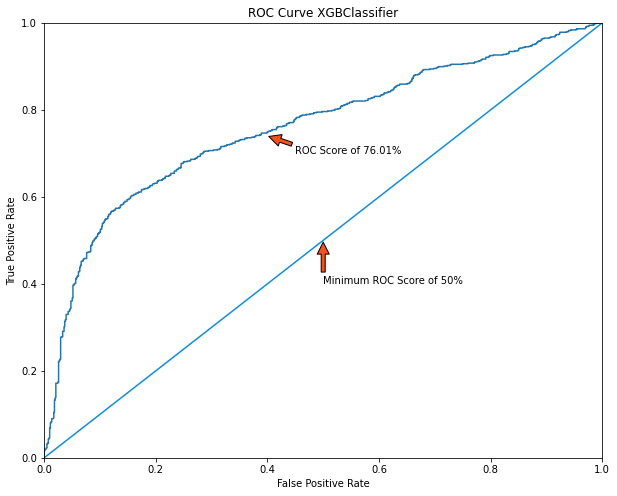

In [57]:
plt.figure(figsize=(10,8))
plt.plot(xgb_fpr, xgb_tpr)
plt.plot([0,1],[0,1], '#0C8EE0')
plt.axis([0,1,0,1])
plt.title('ROC Curve XGBClassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.annotate('ROC Score of 76.01%', xy=(0.4, 0.74), xytext=(0.45,0.70), arrowprops=dict(facecolor='#F75118', shrink=0.05))
plt.annotate('Minimum ROC Score of 50%', xy=(0.5,0.5), xytext=(0.5,0.4), arrowprops=dict(facecolor='#F75118', shrink=0.05))
plt.show()

## Feature Importance

Kita juga ingin melihat seberapa besar sebuah feature mempengaruhi target (deposit).

c:\Users\Margaretha Elaine\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


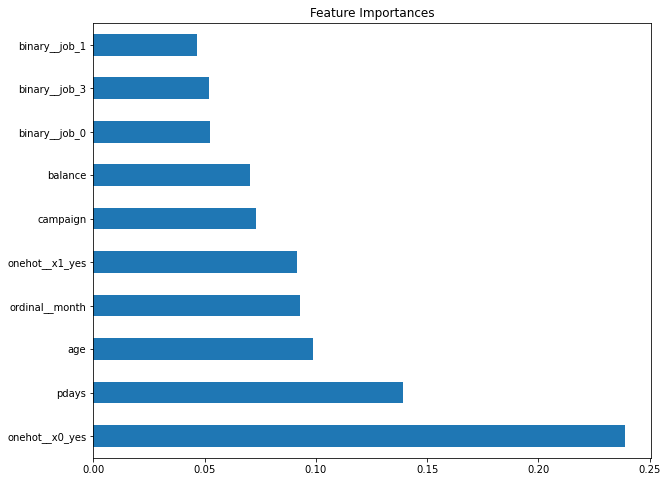

In [53]:
coef = pd.Series(best_model['model'].feature_importances_, transformer.get_feature_names()).sort_values(ascending = False).head(10)

plt.figure(figsize=(10,8))
coef.plot(kind='barh', title='Feature Importances')
plt.show()

Terlihat bahwa feature housing diikuti dengan pdays sangat mempengaruhi seseorang untuk melakukan deposit atau tidak. Dari sini kita juga bisa melihat bahwa ternyata job malah pengaruhnya paling rendah terhadap target. 

## Confusion Matrix

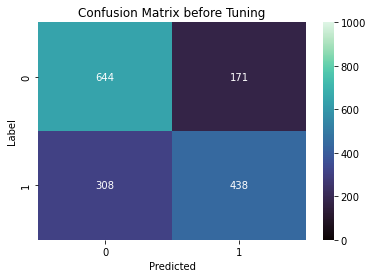

In [54]:
cm_pre = confusion_matrix(y_test, y_pred_base)
sns.heatmap(cm_pre, annot=True, cmap = 'mako', vmax=1000, vmin=0, fmt='g')
plt.title('Confusion Matrix before Tuning')
plt.ylabel('Label')
plt.xlabel('Predicted')
plt.show()

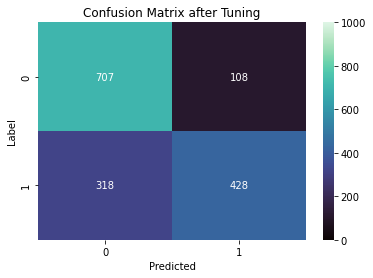

In [55]:
cm = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm, annot=True, cmap = 'mako', vmax=1000, vmin=0, fmt='g')
plt.title('Confusion Matrix after Tuning')
plt.ylabel('Label')
plt.xlabel('Predicted')
plt.show()

**True Negative (Kiri-Atas):** Jumlah calon customer yang diprediksi `tidak mau` membuka deposit dan `benar`

**False Positive (Kanan-Atas):** Jumlah calon customer yang diprediksi `mau` membuka deposit `ternyata tidak`

**False Negative (Kiri-Bawah):** Jumlah calon customer yang diprediksi `tidak mau` membuka deposit `ternyata mau`

**True Positive (Kanan-Bawah):** Jumlah calon customer yang diprediksi `mau` membuka deposit dan `benar`



Dari perbandingan kedua matrix, kita bisa melihat bahwa tuning model berhasil menurunkan angka false positive dan meningkatkan true negative. Dengan begitu kita akan dapat lebih efisien mengfilter calon customer yang tidak mau membuka deposit dan lebih berfokus dengan calon customer yang lebih berpeluang membuka deposit.

In [56]:
print('Classification Report Tuned XGB : \n', report_tuned)

Classification Report Tuned XGB : 
               precision    recall  f1-score   support

           0       0.69      0.87      0.77       815
           1       0.80      0.57      0.67       746

    accuracy                           0.73      1561
   macro avg       0.74      0.72      0.72      1561
weighted avg       0.74      0.73      0.72      1561



Berdasarkan hasil classification report dari model yang sudah kita tuning, kita dapat menyimpulkan bahwa model kita mampu untuk memfilter list calon customer sebesar 86% calon customer yang tidak tertarik dan tidak kita approach, dan juga bisa mendapatkan 57% calon customer yang tertarik untuk membuka deposit dari seluruh calon customer yang tertarik. (bedasarkan nilai recall)

Model kita memiliki ketepatan prediksi calon customer yang tertarik sebesar 80% (precisionnya), jadi jika model kita memprediksi bahwa seorang customer itu tertarik, maka kemungkinan tebakannya benar itu sebesar 79% kurang lebih. Maka masih akan ada customer yang sebenarnya tidak tertarik tetapi diprediksi sebagai kandidat yang tertarik sekitar 23% dari keseluruhan calon customer yang tidak tertarik (berdasarkan recall).



## Conclusion and Recommendation

**Conclusion**

Tujuan utama dari project ini adalah untuk bisa lebih mendalami faktor yang mempengaruhi seorang calon customer untuk membuka deposit, sehingga meningkatkan efektifitas campaign.

Berdasarkan dari analisa dasar diatas, target customer yang paling responsif adalah yang memiliki ciri-ciri dibawah:
- Pekerjaannya student atau retired
- Berusia <30 atau >60
- Mempunyai balance diatas 1000, semakin tinggi semakin tinggi juga peluangnya

Dengan melakukan analisa lebih lanjut dengan menggunakan XGBClassifier kita bisa memprediksi peluang seorang customer akan membuka deposit atau tidak sebelum dilakukan campaignnya. Kita mendapatkan informasi tambahan, dimana housing loan dan pdays sangat mempengaruhi keputusan customer untuk membuka deposit atau tidak.
</br>
</br>

**Recommendation**
- Perusahaan bisa melakukan campaign lebih tinggi pada bulan-bulan berikut : Maret, September, Oktober, dan Desember. Dimana rate untuk pembukaan lebih tinggi
- Perusahaan bisa mendapatkan data pribadi lebih banyak dari calon customer sebelum melakukan campaign, namun hanya data-data yang tidak mengganggu kenyamanan customer (contoh: status pernikahan, jumlah tanggungan, kendaraan pribadi, dll). Nantinya bisa dicoba lagi pada project berikutnya agar bisa mendapatkan model yang lebih baik
- Untuk memperbaiki model ini, disarankan untuk menggunakan GridSearchCV dalam melakukan Hyperparameter Tuning agar bisa mendapatkan parameter yang benar-benar terbaik (belum bisa pada project kali ini karena time constraint, untuk running >8 jam)
- Bisa mencoba dengan menggunakan model lain (contoh: SVM, Naive Bayes)
